# **Amazon Book Review Model Sentiment Analysis with BERT**

In this model we will look at how a prediction of Amazon book reviews written statements being positive or negative. Below we will import the required packages for this modelusing BERT.

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://github.com/KaneEgan/cs39aa_project/blob/main/amazon-book-reviews-with-bert.ipynb)

In [1]:
!pip install transformers

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Importing data subset

In [4]:
df = pd.read_csv("../input/reviews-subset/reviews_subset.csv")
df.shape

(10000, 10)

In [5]:
# View a few of the data we have
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B0006AQ616,Walt Whitman,NaN,A244RGQNVMCDIK,Simon of the Pulpitzer Awards,3/3,5.0,1216857600,Great Reproduction,"I've been doing some research on Whitman, and ..."
1,B000GSDG8E,"Rich Dad, Poor Dad",NaN,A2OS1H34LALKGD,"mobius ""mobiuspowershred""",4/10,2.0,962409600,Where's the BEEEFFFF?,Kinda like all the hype with the new Star Wars...
2,B000QKT4LA,Path of the Jaguar,NaN,A3PM6M7X1GH200,accisse,2/2,3.0,1342396800,Mystery and romance,A tidy little light mystery. It is not a thril...
3,B000HEGHT2,Speaker for the Dead,NaN,ALD7XTUFKNL7D,T. Peck,0/0,5.0,1344297600,"A great vacation read, Orson Scott Card Speake...","The second book in the series, the characters ..."
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,47.0,A2TLFM93VB73B4,Blake7134,2/2,5.0,1314835200,Great Book!,I've been interested in Cleveland history for ...


In [6]:
# Let's check for missing values 
df.isnull().sum()

Id                       0
Title                    2
Price                 8354
User_id               1841
profileName           1841
review/helpfulness       0
review/score             0
review/time              0
review/summary           1
review/text              0
dtype: int64

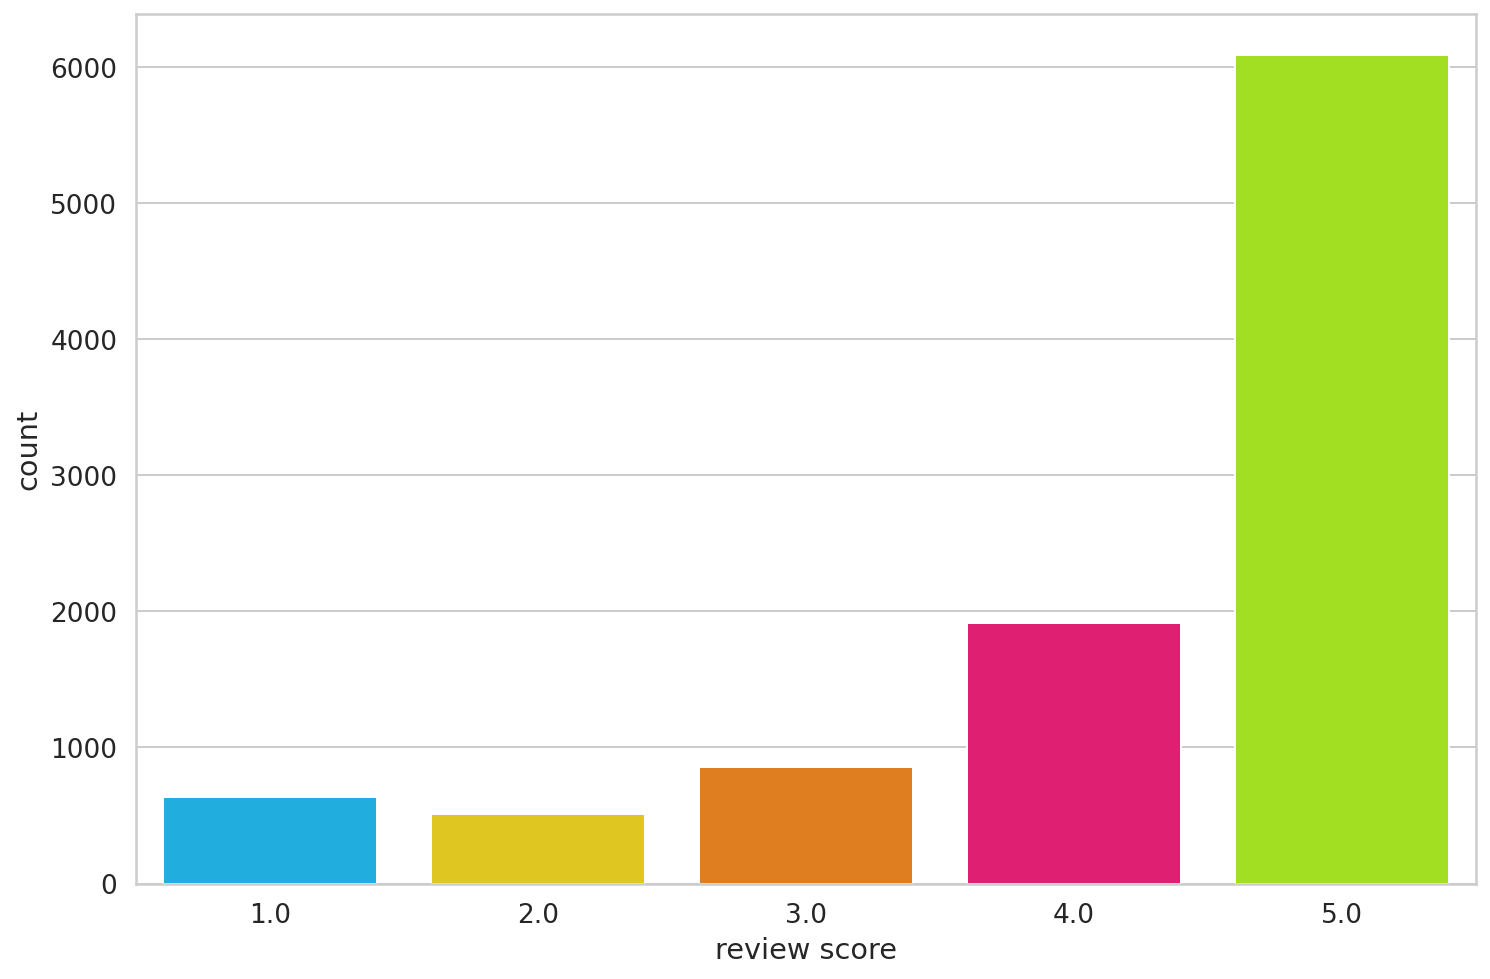

In [7]:
# Let's have a look at the class balance.
sns.countplot(df['review/score'])
plt.xlabel('review score');

In [8]:
# Function to convert score to sentiment
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return 0 #'negative' 
    elif rating == 3:
        return 1 #'neutral' 
    else:
        return 2 # 'positive'

# Apply to the dataset 
df['sentiment'] = df['review/score'].apply(to_sentiment)

In [9]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,sentiment
0,B0006AQ616,Walt Whitman,NaN,A244RGQNVMCDIK,Simon of the Pulpitzer Awards,3/3,5.0,1216857600,Great Reproduction,"I've been doing some research on Whitman, and ...",2
1,B000GSDG8E,"Rich Dad, Poor Dad",NaN,A2OS1H34LALKGD,"mobius ""mobiuspowershred""",4/10,2.0,962409600,Where's the BEEEFFFF?,Kinda like all the hype with the new Star Wars...,0
2,B000QKT4LA,Path of the Jaguar,NaN,A3PM6M7X1GH200,accisse,2/2,3.0,1342396800,Mystery and romance,A tidy little light mystery. It is not a thril...,1
3,B000HEGHT2,Speaker for the Dead,NaN,ALD7XTUFKNL7D,T. Peck,0/0,5.0,1344297600,"A great vacation read, Orson Scott Card Speake...","The second book in the series, the characters ...",2
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,47.0,A2TLFM93VB73B4,Blake7134,2/2,5.0,1314835200,Great Book!,I've been interested in Cleveland history for ...,2


In [ ]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [ ]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

In [ ]:
# Store length of each review 
token_lens = []

# Iterate through the content slide
for txt in df['review/text']:
    tokens = tokenizer.encode(txt, max_length=1500, truncation=True)
    token_lens.append(len(tokens))

In [ ]:
# plot the distribution of review lengths 
sns.distplot(token_lens)
plt.xlim([0, 1500]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 512

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [11]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,sentiment
0,B0006AQ616,Walt Whitman,NaN,A244RGQNVMCDIK,Simon of the Pulpitzer Awards,3/3,5.0,1216857600,Great Reproduction,"I've been doing some research on Whitman, and ...",2
1,B000GSDG8E,"Rich Dad, Poor Dad",NaN,A2OS1H34LALKGD,"mobius ""mobiuspowershred""",4/10,2.0,962409600,Where's the BEEEFFFF?,Kinda like all the hype with the new Star Wars...,0
2,B000QKT4LA,Path of the Jaguar,NaN,A3PM6M7X1GH200,accisse,2/2,3.0,1342396800,Mystery and romance,A tidy little light mystery. It is not a thril...,1
3,B000HEGHT2,Speaker for the Dead,NaN,ALD7XTUFKNL7D,T. Peck,0/0,5.0,1344297600,"A great vacation read, Orson Scott Card Speake...","The second book in the series, the characters ...",2
4,0873384458,Showplace of America: Cleveland's Euclid Avenu...,47.0,A2TLFM93VB73B4,Blake7134,2/2,5.0,1314835200,Great Book!,I've been interested in Cleveland history for ...,2


In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df['review/text'].to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples 
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
# Load the basic BERT model 
bert_model = BertModel.from_pretrained(MODEL_NAME)


In [ ]:
# Build the Sentiment Classifier class 
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

In [ ]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

In [ ]:
# Plot training and validation accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);